In [89]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [90]:
import warnings
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR)

In [91]:
data = pd.read_csv('Datasets/SCRIP/SBIN.csv')
data['Date'] = pd.to_datetime(data['Date'])
startDate = '2018-01-01'
endDate = '2020-01-01'
data = data[(data['Date'] >= startDate) & (data['Date'] <= endDate)]
data['Date'] = (data['Date'] - data['Date'].min()).dt.days
data = data.dropna()

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [92]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data)

In [93]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [94]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [95]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1142
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0246
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0175
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0114
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0114
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0085
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0084
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0105
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0076
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0068
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoc

In [96]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

actual = np.reshape(Y_test, (Y_test.shape[0], 1))
actual = scaler.inverse_transform(actual)

previous = np.reshape(Y_train, (Y_train.shape[0], 1))
previous = scaler.inverse_transform(previous)

overall_actual = previous.copy();
overall_actual = np.append(overall_actual, actual);

overall_predicted = previous.copy();
overall_predicted = np.append(overall_predicted, predictions);

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [97]:
# Calculate the Mean Absolute Error
k = train_size
mae = mean_absolute_error(overall_actual[k:], overall_predicted[k:])
print('Mean Absolute Error:', mae)

# Calculate the Mean Squared Error
mse = mean_squared_error(overall_actual[k:], overall_predicted[k:])
print('Mean Squared Error:', mse)

# Calculate the Root Mean Squared Error
rmse = math.sqrt(mean_squared_error(overall_actual[k:], overall_predicted[k:]))
print('Root Mean Squared Error:', rmse)

# Calculate the R2 score
r2 = r2_score(overall_actual[k:], overall_predicted[k:])
print(f'R2 score: {r2}')

Mean Absolute Error: 10.797565448467546
Mean Squared Error: 186.2362402183906
Root Mean Squared Error: 13.646839935252066
R2 score: 0.8402385740088959


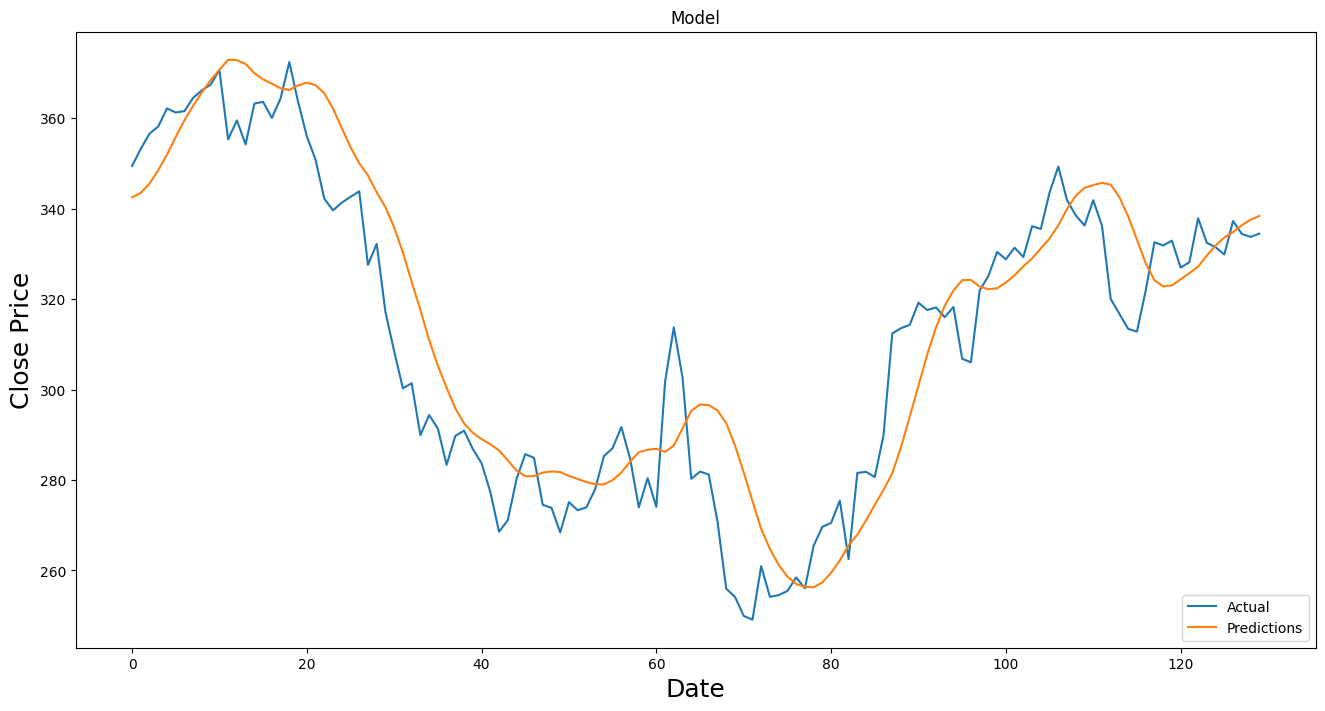

In [98]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(actual)
plt.plot(predictions)
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.show()

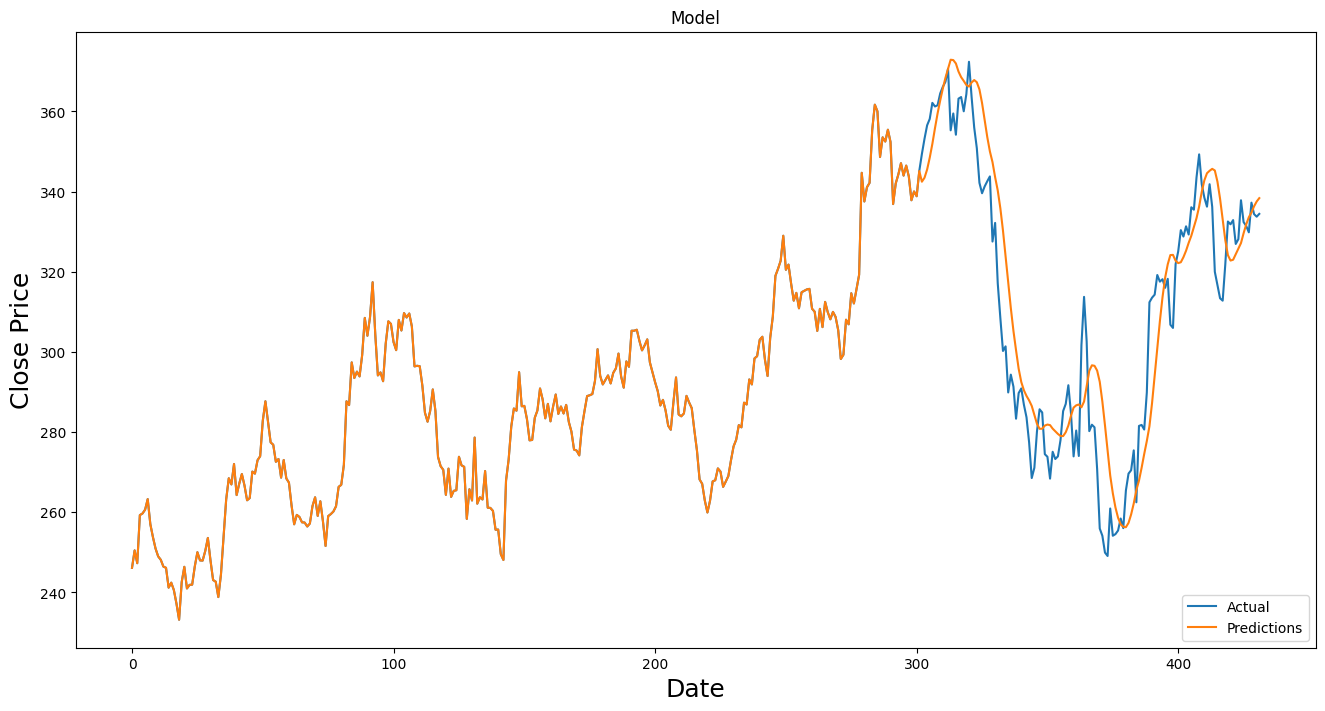

In [99]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(overall_actual)
plt.plot(overall_predicted)
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.show()